## install pre-requistetes

In [ ]:
!pip install scanpy
!pip install scvi-tools

## load pacakges


In [50]:
import pandas as pd
import numpy as np
import scanpy as sc
import scvi
from sklearn.cluster import KMeans

## load data into Anndata object.
to keep pre-processing consistent with what was done with R we will just be hard coding in the cells to keep. It is not efficent, but it simple and works for scale of data we are working with.  

In [26]:
base_path = '/content/drive/MyDrive/spring_2024/single_cell_sequencing/final_project/'

cell_names =  pd.read_csv(base_path+'Cells.csv')['cell_name'].values
filtered_cell_names = pd.read_csv(base_path + 'filtered_cell_names.csv')['x'].values
index_of_cells = [np.where(cell_names == cell_name)[0][0] for cell_name in filtered_cell_names]

## add in only core data relavent to clustering.
anndata = sc.read_mtx(base_path+'Exp_data_UMIcounts.mtx').T[index_of_cells, :]
anndata.obs["cell_name"] = filtered_cell_names
anndata.obs["cell_type"] = pd.read_csv(base_path+'Cells.csv')['cell_type'].values[index_of_cells]


<ipython-input-26-f7e8c2b44c27>:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  anndata.obs["cell_name"] = filtered_cell_names


## Set Model Hyperparameters
There are two hyperparameters to consider when fitting an scVI model. The First is wether to use a base Single Cell Variation Inference (scVI) model as proposed by [Lopez et al](https://www.nature.com/articles/s41592-018-0229-2) or use a Single Cell Variation Inference model with a linear decoder (scVI-LD) as proposed by [Svensson et al](https://academic.oup.com/bioinformatics/article/36/11/3418/5807606?login=false). An scVI-LD model is recommended in this case as it increases computational efficiency with only minor losses to performance. The second parameter to consider in this model is wether or not to use cell labels. Doing so generally increases clustering performance, but cell labels will not always be available. In this case as we have cell labels we chose to use them. We made them parameters that are easy to change, so feel free to mess around with them and see how performance varies.



In [46]:
LD = True
use_cell_labels = True

## Fit model

In [63]:
## set scVI-LD Model
if LD:
  if use_cell_labels:
    scvi.model.LinearSCVI.setup_anndata(anndata, labels_key='cell_type') #Format data for wokring with scVI-Tools models
  else:
    scvi.model.LinearSCVI.setup_anndata(anndata) #Format data for wokring with scVI-Tools models
  model = scvi.model.LinearSCVI(anndata)

## Set up scVI model
if not LD:
  if use_cell_labels:
    scvi.model.SCVI.setup_anndata(anndata, labels_key='cell_type')
  else:
    scvi.model.SCVI.setup_anndata(anndata)
  model = scvi.model.SCVI(anndata)
model.train() # train model
model.save(base_path+'scVI_ld.pt', overwrite=True) ## save model
np.save(model.get_latent_representation(), base_path+'latent.npy') ## save learned reprentations


/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


## Get Umaps and cluster the data

In [65]:
anndata.obsm['latent_representation'] = np.load(base_path+'latent.npy')## load saved embedings
sc.pp.neighbors(anndata, n_neighbors=10, use_rep="latent_representation") ## compute nearest neighbor distances for umap
sc.tl.umap(anndata) ## compute umap representations
kmeans = KMeans(n_clusters=8)##.fit(anndata.obsm['X_pca'])
anndata.obs['cluster_labels'] =  kmeans.fit_predict(anndata.obsm['latent_representation'])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## plot resulting clusters

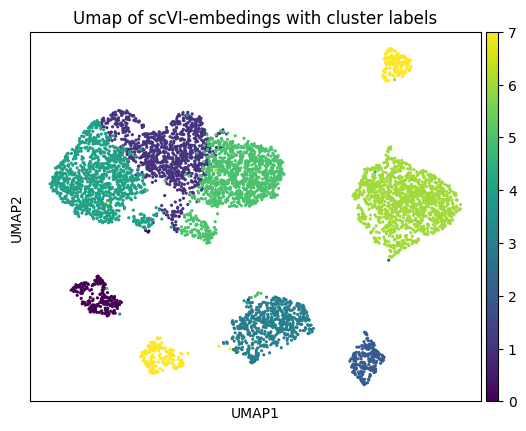

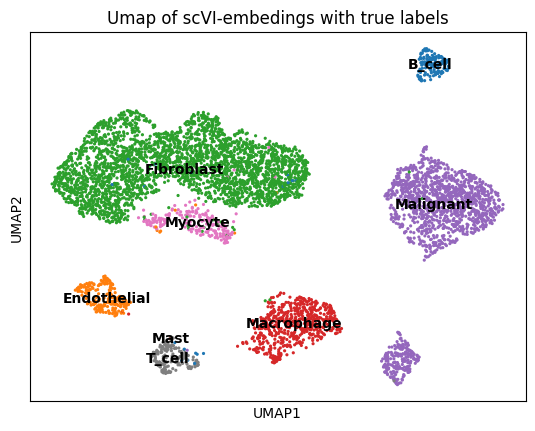

In [66]:
title = "Umap of scVI-embedings with cluster labels"
umap_plot = sc.pl.umap(anndata, color='cluster_labels',title=title, legend_loc='on data')
title = "Umap of scVI-embedings with true labels"
umap_plot = sc.pl.umap(anndata, color='cell_type',title=title, legend_loc='on data')